In [1]:
import sys
sys.path.append("..") # Adds the module to path

# DeepTrack.features

This notebook introduces the DeepTrack.features module.

## What is a feature?

Features are instances of the abstract class `Feature` and are responsible for modifying images. Each implementation of the class `Feature` needs to define a method `get(image, **kwargs)`, takes an image as an input and should return an updated image. This can be additive, such as adding a particle or gaussian noise, or non-additive, such as poisson noise or a low-pass filter. The image that is modified is in itself an instance of the class Image, which for now can be thought of as a normal numpy ndarray.

It is very important to note that features do _not_ create images, they modify images. As such, they always need an image as an input. 

When a feature is created, keyword arguments can be passed to its constructor. These arguments are stored as [properties](properties_example.ipynb) of the feature, which determine how the feature is resolved. When a feature is updated using the method `update()`, all of the properties are updated as well. When a feature is resolved using the method `resolve(image)`, the current value of all properties is sent through the method `get(image, **kwargs)` as keyword arguments.

In [2]:
import numpy as np

from DeepTrack.features import Feature
from DeepTrack.Image import Image


class Foo(Feature):
    def get(self, image, value=None):
        print("value is", value)
        return image

foo1 = Foo(value=1)
foo2 = Foo(value="bar")
foo3 = Foo()

res = foo1.resolve(Image([]))
res = foo2.resolve(Image([]))
res = foo3.resolve(Image([]))

value is 1
value is bar
value is None


Note, since the values are stored as instances of Property, you can always replace values with standard structures such as list or lambda functions to create more complicated behaviors

In [3]:
F1 = Foo(value=lambda: np.random.rand() - 0.5)
F2 = Foo(value=["bar", "baz"])

res = F1.resolve(Image([]))
res = F2.resolve(Image([]))

value is 0.26922704480630055
value is bar


## Operations defind on features

Features can be combined to create a feature series, which is a series of features that are evaluated sequentially. This is done using the add operator (+), the multiply operator (\*), and the power operator (\*\*). 

### Adding features (+)
The add operator (+) combines two features such that the output of the left side is set as the input to the feature to the right. For example, `foobar = foo + bar`, where foo and bar are features. Here, when an image is resolved from foobar, it first resolves an image from foo, then uses this image as the input to resolve an image from bar.

In [4]:
foobar = Foo(value="left side") + Foo(value="right side")

R = foobar.resolve(Image([]))

value is left side
value is right side


### Multiplying feature with number (\*)

The mul operator (\*) takes a feature ´F´ and a number ´p´ and creates a new feature, that has a probability `1-p` to be skipped. 

In [5]:
foo = Foo(value=0)*0.5
for i in range(1,10):
    foo = foo + Foo(value=i)*0.5

res = foo.resolve(Image([]))

value is 4
value is 6
value is 8
value is 9


### Exponentiating feature with integer (\*\*)

The pow operator (\*\*) takes a feature and an integer to create several deep copies of the feature. Then, `Foo() ** 5` will create 5 deep copies of the instance of Foo and add them to the feature series. Since this is done at resolve time, the right hand side can be any value that returns an integer when sampled. 

Note that that since the features are deep copied, properties that reference these features may produce unintended results. 

In [6]:
foo = Foo(value = ["bar", "baz", "qux", "quux"]) 
res = (foo ** 5).resolve(Image([]))

print("\nUsing list")
res = (foo ** [3,4,5]).resolve(Image([]))

value is quux
value is qux
value is bar
value is quux
value is qux

Using list
value is bar
value is bar
value is qux
value is bar
value is qux


## Example - Image with random circles

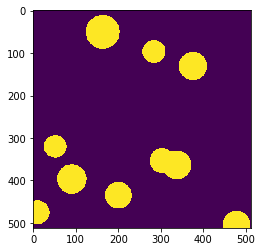

In [53]:
from matplotlib import pyplot as plt

class Circle(Feature):
    def get(self, image, position=None, radius=None, intensity=None):
        X, Y = np.meshgrid(np.arange(image.shape[0]), np.arange(image.shape[1]))
        mask = (X - position[0]) ** 2 + (Y - position[1]) ** 2 < radius ** 2
        image[mask] = intensity
        return image

circle = Circle(
    position=lambda: np.random.rand(2) * 512,
    radius=lambda: 20 + np.random.rand() * 20,
    intensity=1
)

input_image = Image(np.zeros((512,512)))

output_image = (circle ** 10).resolve(input_image) 

plt.imshow(output_image)
plt.show()

## Example - Image with stacked circles

It's not unusual for a feature to depend on some other feature. Due to the way features are updated, we can only reliably depend on features that are resolved earlier in the sequence. Dependent features can typically not be wrapped by a \*\* operator, since the reference pointers will not be correctly copied. 

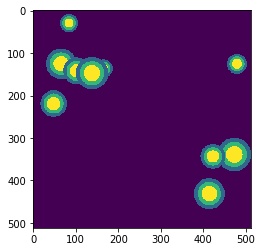

In [70]:
# Due to python scoping rules, we need to move this evaluation
# to its own scope.
def get_position(base):
    def func():
        return base.properties["position"].current_value
    return func

def get_radius(base, mul_factor):
    def func():
        return base.properties["radius"].current_value*mul_factor
    return func

# Since layer1 references the instance "base", we can't use the ** syntax
# to duplicate the feature. Instead we use a for-loop.
for i in range(10):
    
    base = Circle(
        position=lambda: np.random.rand(2) * 512,
        radius=lambda: 20 + np.random.rand() * 20,
        intensity=1
    )
   
    layer1 = Circle(
        position=get_position(base),
        radius=get_radius(base, 0.75),
        intensity=2
    )

    layer2 = Circle(
        position=get_position(base),
        radius=get_radius(base,0.5),
        intensity=3
    )
    
    stack = base + layer1 + layer2
    
    if i == 0:
        features = stack
    else: 
        features = features + stack
        
input_image = Image(np.zeros((512,512)))
output_image = features.resolve(input_image) 

plt.imshow(output_image)
plt.show()

## Example - Image with pow operator friendly stacked circles 

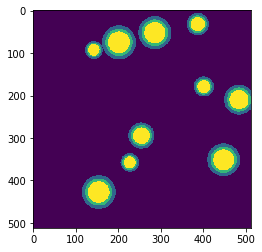

In [109]:
class StackedCircles(Feature):
    def get(self, image, position=None, radius=None, feature_list=None):
        
        for feature in feature_list:
            feature.properties["position"].current_value = position
            feature.properties["radius"].current_value = radius
            
            radius *= 0.8
            image = feature.resolve(image)
        return image
            
base = Circle(
    position=None,
    radius=None,
    intensity=1
)

layer1 = Circle(
    position=None,
    radius=None,
    intensity=2
)

layer2 = Circle(
    position=None,
    radius=None,
    intensity=3
)

stack = StackedCircles(
    position=lambda: np.random.rand(2)*512,
    radius=lambda: 20 + 20*np.random.rand(),
    feature_list=lambda: [base, layer1, layer2]
)

input_image = Image(np.zeros((512,512)))
output_image = (stack ** 10).resolve(input_image) 

plt.imshow(output_image)
plt.show()

## Example - Image with random non-overlapping circles

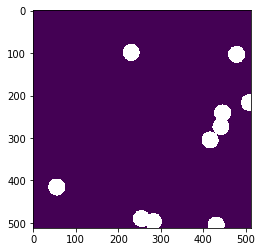

In [107]:
from matplotlib import pyplot as plt

RADIUS = 20 # Fixed radius since accessing properties of self is more difficult.

def NonOverlappingPosition(previous, position_function, radius):
    def func():
        prev_positions = [circle.properties["position"].current_value for circle in previous]
        prev_radius = [circle.properties["radius"].current_value for circle in previous]

        overlapping = True
        while overlapping:
            position = position_function()
            overlapping = any([np.sum((position - prev_position) ** 2) < radius ** 2 * 2 for prev_position in prev_positions])
        return position
    return func
            
    
circles = []
for i in range(10):
    circle = Circle(
        position=NonOverlappingPosition(circles[:], lambda: np.random.rand(2)*512, RADIUS),
        radius= RADIUS
    )
    circles.append(circle)
    if i == 0:
        circle_features = circle
    else:
        circle_features = circle_features + circle


input_image = Image(np.zeros((512,512)))
output_image = circle_features.resolve(input_image) 

plt.imshow(output_image)
plt.show()